<a href="https://colab.research.google.com/github/SerDavidE/NashvilleClimateCrashes/blob/main/Final_Project_Data_Science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Explore, clean, and transform the main datasets: The Traffic Data & The Weather Dataset.

In [1]:
import pandas as pd

In [2]:
# File paths
accident_file_path = '/content/drive/MyDrive/Colab Notebooks/Final_Project/Filtered_US_Accidents.csv'
weather_file_path = '/content/drive/MyDrive/Colab Notebooks/Final_Project/filtered_daily_weather.csv'

accident_data = pd.read_csv(accident_file_path)
weather_data = pd.read_csv(weather_file_path)

# Initial overview
accident_data.head(), weather_data.head()

(         ID   Source  Severity           Start_Time             End_Time  \
 0  A-512591  Source2         3  2022-09-08 09:50:56  2022-09-08 10:18:52   
 1  A-512609  Source2         3  2022-09-08 09:54:20  2022-09-08 10:21:01   
 2  A-512680  Source2         3  2022-09-08 08:43:45  2022-09-08 09:13:19   
 3  A-512770  Source2         2  2022-09-08 08:11:04  2022-09-08 08:40:13   
 4  A-512806  Source2         3  2022-09-08 09:07:37  2022-09-08 09:34:53   
 
    Start_Lat  Start_Lng  End_Lat  End_Lng  Distance(mi)  ... Roundabout  \
 0  36.085560 -86.762962      NaN      NaN          0.81  ...      False   
 1  36.205391 -86.775261      NaN      NaN          0.39  ...      False   
 2  36.112938 -86.723541      NaN      NaN          0.00  ...      False   
 3  36.082279 -86.762108      NaN      NaN          0.81  ...      False   
 4  36.204632 -86.777000      NaN      NaN          1.00  ...      False   
 
   Station   Stop Traffic_Calming Traffic_Signal Turning_Loop Sunrise_Sunset  

In [3]:
# Dropping columns with more than 70% missing values in both datasets
threshold = 0.7
weather_data.dropna(thresh=int(threshold * len(weather_data)), axis=1, inplace=True)
accident_data.dropna(thresh=int(threshold * len(accident_data)), axis=1, inplace=True)

# Forward-fill for imputation for time-series data in weather and accident datasets
weather_data.sort_values(by=['date', 'city_name'], inplace=True)
accident_data.sort_values(by=['Start_Time', 'City'], inplace=True)

# Forward fill for weather data
weather_data.fillna(method='ffill', inplace=True)

# Forward fill for accident data time-series related columns
time_series_related_columns_accident = ['Start_Time', 'End_Time', 'Weather_Timestamp']
accident_data[time_series_related_columns_accident] = accident_data[time_series_related_columns_accident].fillna(method='ffill')

# Other columns in both datasets, using median for imputation
weather_data.fillna(weather_data.median(), inplace=True)
accident_data.fillna(accident_data.median(), inplace=True)

# Conversion from imperial to metric system for accident data
accident_data['Distance(km)'] = accident_data['Distance(mi)'] * 1.60934
accident_data['Temperature(C)'] = (accident_data['Temperature(F)'] - 32) * 5/9
accident_data['Wind_Chill(C)'] = (accident_data['Wind_Chill(F)'] - 32) * 5/9
accident_data['Pressure(hPa)'] = accident_data['Pressure(in)'] * 33.8639
accident_data['Visibility(km)'] = accident_data['Visibility(mi)'] * 1.60934
accident_data['Wind_Speed(kmh)'] = accident_data['Wind_Speed(mph)'] * 1.60934
accident_data['Precipitation(mm)'] = accident_data['Precipitation(in)'] * 25.4

# Dropping original columns with imperial units
imperial_columns = ['Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)']
accident_data.drop(columns=imperial_columns, inplace=True)

# Checking if the missing values are handled and the unit conversion is successful
accident_data.isnull().sum(), weather_data.isnull().sum(), accident_data.head()

<ipython-input-3-ee439837bd86>:18: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  weather_data.fillna(weather_data.median(), inplace=True)
<ipython-input-3-ee439837bd86>:19: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  accident_data.fillna(accident_data.median(), inplace=True)


(ID                         0
 Source                     0
 Severity                   0
 Start_Time                 0
 End_Time                   0
 Start_Lat                  0
 Start_Lng                  0
 Description                0
 Street                    40
 City                       0
 County                     0
 State                      0
 Zipcode                    0
 Country                    0
 Timezone                   0
 Airport_Code               0
 Weather_Timestamp          0
 Humidity(%)                0
 Wind_Direction           205
 Weather_Condition        103
 Amenity                    0
 Bump                       0
 Crossing                   0
 Give_Way                   0
 Junction                   0
 No_Exit                    0
 Railway                    0
 Roundabout                 0
 Station                    0
 Stop                       0
 Traffic_Calming            0
 Traffic_Signal             0
 Turning_Loop               0
 Sunrise_S

## Separate datasets for each city (Madison, Boise, and Nashville) by merging weather and accident data

In [4]:
# Converting 'date' column in weather_data and 'Start_Time' column in accident_data to datetime format for merging
weather_data['date'] = pd.to_datetime(weather_data['date'])
accident_data['Start_Time'] = pd.to_datetime(accident_data['Start_Time']).dt.date
accident_data['Start_Time'] = pd.to_datetime(accident_data['Start_Time'])

# Filtering accident data for each city
accident_data_madison = accident_data[accident_data['City'] == 'Madison']
accident_data_boise = accident_data[accident_data['City'] == 'Boise']
accident_data_nashville = accident_data[accident_data['City'] == 'Nashville']

# Filtering weather data for each city
weather_data_madison = weather_data[weather_data['city_name'] == 'Madison']
weather_data_boise = weather_data[weather_data['city_name'] == 'Boise']
weather_data_nashville = weather_data[weather_data['city_name'] == 'Nashville']

# Merging accident and weather data for each city
merged_data_madison = pd.merge(accident_data_madison, weather_data_madison, how='inner', left_on=['Start_Time'], right_on=['date'])
merged_data_boise = pd.merge(accident_data_boise, weather_data_boise, how='inner', left_on=['Start_Time'], right_on=['date'])
merged_data_nashville = pd.merge(accident_data_nashville, weather_data_nashville, how='inner', left_on=['Start_Time'], right_on=['date'])

# Verifying the merge operation and shape of the new datasets
merged_data_madison.shape, merged_data_boise.shape, merged_data_nashville.shape

((8025, 54), (2602, 54), (72670, 54))

# Datasets Overview:

## Load Nashville Dataset and Initial Exploration

In [5]:
# Loading Nashville dataset
nashville_filepath = '/content/drive/MyDrive/Colab Notebooks/Final_Project/Merged_Datasets/merged_data_nashville.csv'
nashville_data = pd.read_csv(nashville_filepath)

# Displaying basic information about the dataset
nashville_info = nashville_data.info()

nashville_head = nashville_data.head()

nashville_info, nashville_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72670 entries, 0 to 72669
Data columns (total 54 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     72670 non-null  object 
 1   Source                 72670 non-null  object 
 2   Severity               72670 non-null  int64  
 3   Start_Time             72670 non-null  object 
 4   End_Time               72670 non-null  object 
 5   Start_Lat              72670 non-null  float64
 6   Start_Lng              72670 non-null  float64
 7   Description            72670 non-null  object 
 8   Street                 72631 non-null  object 
 9   City                   72670 non-null  object 
 10  County                 72670 non-null  object 
 11  State                  72670 non-null  object 
 12  Zipcode                72670 non-null  object 
 13  Country                72670 non-null  object 
 14  Timezone               72670 non-null  object 
 15  Ai

(None,
           ID   Source  Severity  Start_Time             End_Time  Start_Lat  \
 0  A-3498268  Source1         2  2016-06-17  2016-06-17 21:30:00   36.16841   
 1  A-3498360  Source1         2  2016-06-21  2016-06-21 16:51:32   36.15220   
 2  A-3498292  Source1         2  2016-06-21  2016-06-21 14:52:52   36.04730   
 3  A-3498295  Source1         2  2016-06-21  2016-06-21 15:09:56   36.14966   
 4  A-3498291  Source1         2  2016-06-21  2016-06-21 15:15:23   36.15506   
 
    Start_Lng                               Description           Street  \
 0  -86.76606         At Shelby Ave/Exit 84 - Accident.           I-24 W   
 1  -86.84222              At Charlotte Ave - Accident.   Charlotte Pike   
 2  -86.86272           At Old Hickory Blvd - Accident.   Hillsboro Pike   
 3  -86.76979                  At McCann St - Accident.        McCann St   
 4  -86.77947  At US-31/James Robertson Pky - Accident.        8th Ave S   
 
         City  ... station_id  city_name        date 

## Load Boise Data and Initial Exploration

In [6]:
# Loading the Boise dataset
boise_filepath = '/content/drive/MyDrive/Colab Notebooks/Final_Project/Merged_Datasets/merged_data_boise.csv'
boise_data = pd.read_csv(boise_filepath)

# Displaying basic information about the dataset
boise_info = boise_data.info()

boise_head = boise_data.head()

boise_info, boise_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2602 entries, 0 to 2601
Data columns (total 54 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     2602 non-null   object 
 1   Source                 2602 non-null   object 
 2   Severity               2602 non-null   int64  
 3   Start_Time             2602 non-null   object 
 4   End_Time               2602 non-null   object 
 5   Start_Lat              2602 non-null   float64
 6   Start_Lng              2602 non-null   float64
 7   Description            2602 non-null   object 
 8   Street                 2602 non-null   object 
 9   City                   2602 non-null   object 
 10  County                 2602 non-null   object 
 11  State                  2602 non-null   object 
 12  Zipcode                2602 non-null   object 
 13  Country                2602 non-null   object 
 14  Timezone               2602 non-null   object 
 15  Airp

(None,
           ID   Source  Severity  Start_Time             End_Time  Start_Lat  \
 0  A-3551617  Source1         2  2016-06-21  2016-06-21 11:37:45  43.618497   
 1  A-3551929  Source1         2  2016-06-22  2016-06-23 05:10:48  43.592070   
 2  A-3552373  Source1         2  2016-06-26  2016-06-26 21:48:39  43.597060   
 3  A-3553161  Source1         2  2016-06-30  2016-07-01 05:10:31  43.384860   
 4  A-3555546  Source1         2  2016-07-25  2016-07-26 03:59:25  43.618460   
 
     Start_Lng                                 Description  \
 0 -116.228943     At US-20/US-26/Fairview Ave - Accident.   
 1 -116.278420  At Overland Rd/Cole Rd/Exit 50 - Accident.   
 2 -116.295150                        At I-184 - Accident.   
 3 -115.996810          At Mayfield Rd/Exit 71 - Accident.   
 4 -116.240880                    At Curtis Rd - Accident.   
 
                           Street   City  ... station_id city_name        date  \
 0                        US-26 W  Boise  ...      7268

## Load Madison Dataset and Initial Exploration

In [7]:
# Loading the Madison dataset
madison_filepath = '/content/drive/MyDrive/Colab Notebooks/Final_Project/Merged_Datasets/merged_data_madison.csv'
madison_data = pd.read_csv(madison_filepath)

# Displaying basic information about the dataset
madison_info = madison_data.info()

madison_head = madison_data.head()

madison_info, madison_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8025 entries, 0 to 8024
Data columns (total 54 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     8025 non-null   object 
 1   Source                 8025 non-null   object 
 2   Severity               8025 non-null   int64  
 3   Start_Time             8025 non-null   object 
 4   End_Time               8025 non-null   object 
 5   Start_Lat              8025 non-null   float64
 6   Start_Lng              8025 non-null   float64
 7   Description            8025 non-null   object 
 8   Street                 8024 non-null   object 
 9   City                   8025 non-null   object 
 10  County                 8025 non-null   object 
 11  State                  8025 non-null   object 
 12  Zipcode                8025 non-null   object 
 13  Country                8025 non-null   object 
 14  Timezone               8025 non-null   object 
 15  Airp

(None,
           ID   Source  Severity  Start_Time             End_Time  Start_Lat  \
 0  A-3498517  Source1         2  2016-06-21  2016-06-21 22:26:42  43.043220   
 1  A-3498994  Source1         4  2016-06-22  2016-06-22 21:50:14  43.106426   
 2  A-3499557  Source1         2  2016-06-23  2016-06-24 00:32:10  36.261040   
 3  A-3499890  Source1         3  2016-06-24  2016-06-24 21:06:48  36.261040   
 4  A-3499926  Source1         3  2016-06-24  2016-06-24 22:10:35  36.261040   
 
    Start_Lng                                        Description  \
 0 -89.369140        At CR-MC/John Nolen Dr/Exit 263 - Accident.   
 1 -89.320523  Closed at US-51/Stoughton Rd - Road closed due...   
 2 -86.738180  Between TN-45/Old Hickory Blvd/Exit 92 and N-3...   
 3 -86.738180  Between TN-45/Old Hickory Blvd/Exit 92 and N-3...   
 4 -86.738180      At TN-45/Old Hickory Blvd/Exit 92 - Accident.   
 
              Street     City  ... station_id city_name        date  season  \
 0  W Beltline Hwy E  

## Spatial Distribution of Accidents in Nashville:

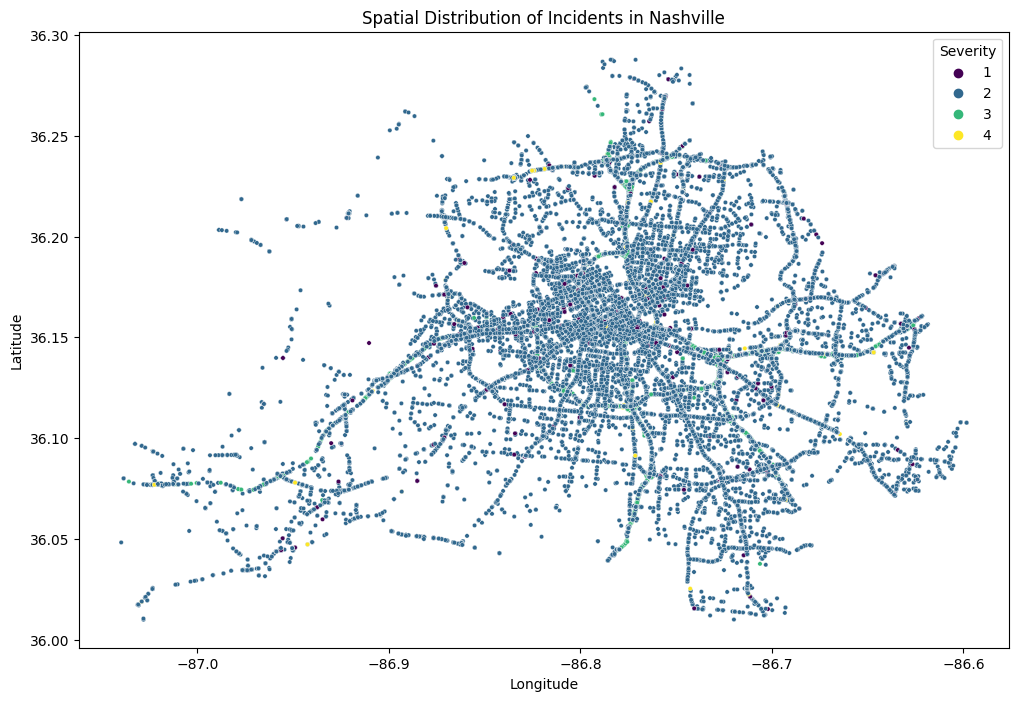

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Initializing the figure
plt.figure(figsize=(12,8))

# Creation of a scatter plot for Spatial Distribution of Accidents in Nashville
sns.scatterplot(x='Start_Lng', y='Start_Lat', hue='Severity', data=nashville_data, palette='viridis', s=10)
plt.title(f'Spatial Distribution of Incidents in Nashville')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

# Step 2: Data Exploration, Cleaning, and Transformation

## Basic statistical properties

In [9]:
# Displaying basic statistical properties of the numerical variables in the dataset
nashville_describe = nashville_data.describe(include=[float, int]).transpose()

nashville_describe

,count,mean,std,min,25%,50%,75%,max
Severity,72670.0,2.140512,0.406944,1.000000,2.000000,2.000000,2.000000,4.000000
Start_Lat,72670.0,36.144289,0.045692,36.009960,36.115716,36.148190,36.169006,36.287689
Start_Lng,72670.0,-86.766799,0.062545,-87.039818,-86.796084,-86.768509,-86.727226,-86.598335
Humidity(%),72670.0,61.715137,19.892943,13.000000,45.000000,63.000000,80.000000,100.000000
Distance(km),72670.0,0.466684,1.117821,0.000000,0.000000,0.000000,0.399116,24.025837
Temperature(C),72670.0,17.223026,10.009140,-18.333333,9.444444,18.333333,25.000000,37.777778
Wind_Chill(C),72670.0,15.784923,10.207768,-30.000000,10.555556,16.666667,22.777778,37.777778
Pressure(hPa),72670.0,1002.884893,11.752284,974.603042,994.244104,998.985050,1012.869249,1043.008120
Visibility(km),72670.0,14.817795,3.386209,0.160934,16.093400,16.093400,16.093400,16.093400
Wind_Speed(kmh),72670.0,12.120691,7.224886,0.000000,8.046700,11.265380,16.093400,201.167500


## Data Cleaning

In [10]:
# Identifying columns with missing values and their count
missing_values = nashville_data.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

missing_values

Wind_Direction       153
Weather_Condition     87
Street                39
dtype: int64

In [11]:
# Fill missing categorical values with 'Unknown'
nashville_data['Wind_Direction'].fillna('Unknown', inplace=True)
nashville_data['Weather_Condition'].fillna('Unknown', inplace=True)
nashville_data['Street'].fillna('Unknown', inplace=True)

# Checking again for any missing values
missing_values_after = nashville_data.isnull().sum().sum()

missing_values_after

0

## Addressing potential outliers in the dataset:

In [12]:
import numpy as np

# Function to find and remove outliers using IQR method
def remove_outliers_iqr(df, columns):
    cleaned_df = df.copy()
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        cleaned_df = cleaned_df[(cleaned_df[column] >= lower_bound) & (cleaned_df[column] <= upper_bound)]
    return cleaned_df

# Defining numerical columns to check for outliers
numerical_columns = ['Severity', 'Humidity(%)', 'Distance(km)', 'Temperature(C)',
                     'Wind_Speed(kmh)', 'Precipitation(mm)', 'avg_temp_c',
                     'min_temp_c', 'max_temp_c', 'avg_wind_speed_kmh']

# Removing outliers from Nashville dataset
nashville_cleaned = remove_outliers_iqr(nashville_data, numerical_columns)

# Checking the shape of the cleaned dataset
original_shape = nashville_data.shape
cleaned_shape = nashville_cleaned.shape

original_shape, cleaned_shape

((72670, 54), (44650, 54))

## Converting date columns to datetime objects

In [13]:
# Converting date columns to datetime objects
nashville_cleaned['Start_Time'] = pd.to_datetime(nashville_cleaned['Start_Time'])
nashville_cleaned['End_Time'] = pd.to_datetime(nashville_cleaned['End_Time'])
nashville_cleaned['Weather_Timestamp'] = pd.to_datetime(nashville_cleaned['Weather_Timestamp'])

# Creating new feature: Duration of the accident
nashville_cleaned['Duration'] = (nashville_cleaned['End_Time'] - nashville_cleaned['Start_Time']).dt.total_seconds() / 60  # in minutes

# Checking the data types of the transformed columns and the newly created column
datetime_dtypes = nashville_cleaned[['Start_Time', 'End_Time', 'Weather_Timestamp', 'Duration']].dtypes

datetime_dtypes

Start_Time           datetime64[ns]
End_Time             datetime64[ns]
Weather_Timestamp    datetime64[ns]
Duration                    float64
dtype: object

# Step 3: Exploratory Data Analysis (EDA)


## 3.1 Univariate Analysis

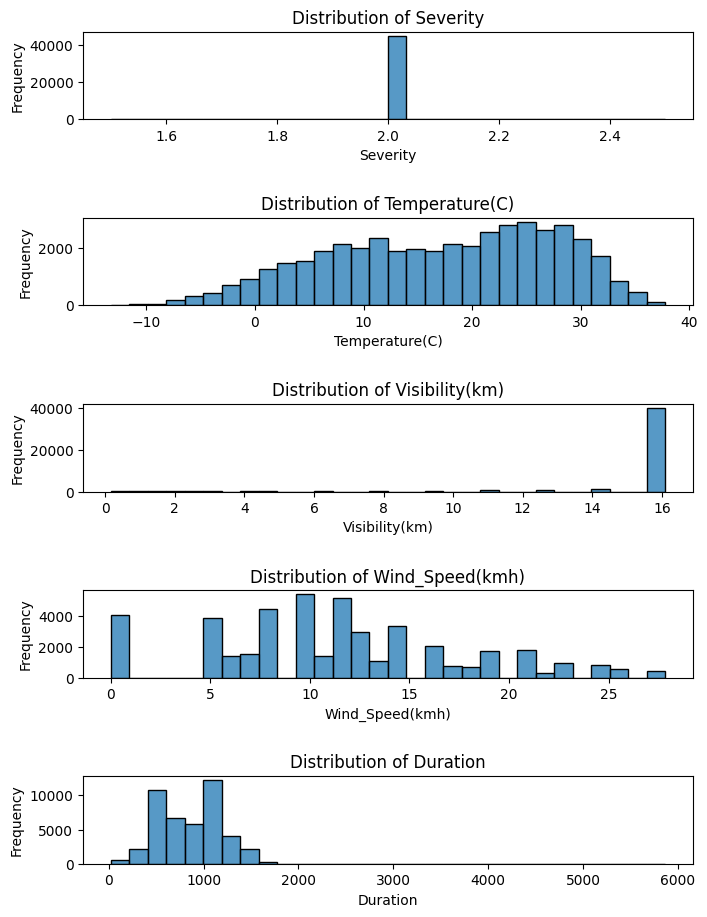

In [14]:
# Defining the numerical variables to be plotted
numerical_vars = ['Severity', 'Temperature(C)', 'Visibility(km)', 'Wind_Speed(kmh)', 'Duration']

# Setting up the matplotlib figure
fig, axes = plt.subplots(len(numerical_vars), 1, figsize=(8, 10))
fig.tight_layout(pad=5.0)

# Plotting histograms for numerical variables
for ax, var in zip(axes, numerical_vars):
    sns.histplot(nashville_cleaned[var], kde=False, bins=30, ax=ax)
    ax.set_title(f'Distribution of {var}')
    ax.set_xlabel(var)
    ax.set_ylabel('Frequency')

plt.show()

## Distribution of some categorical variables, focusing on Weather_Condition and Sunrise_Sunset.

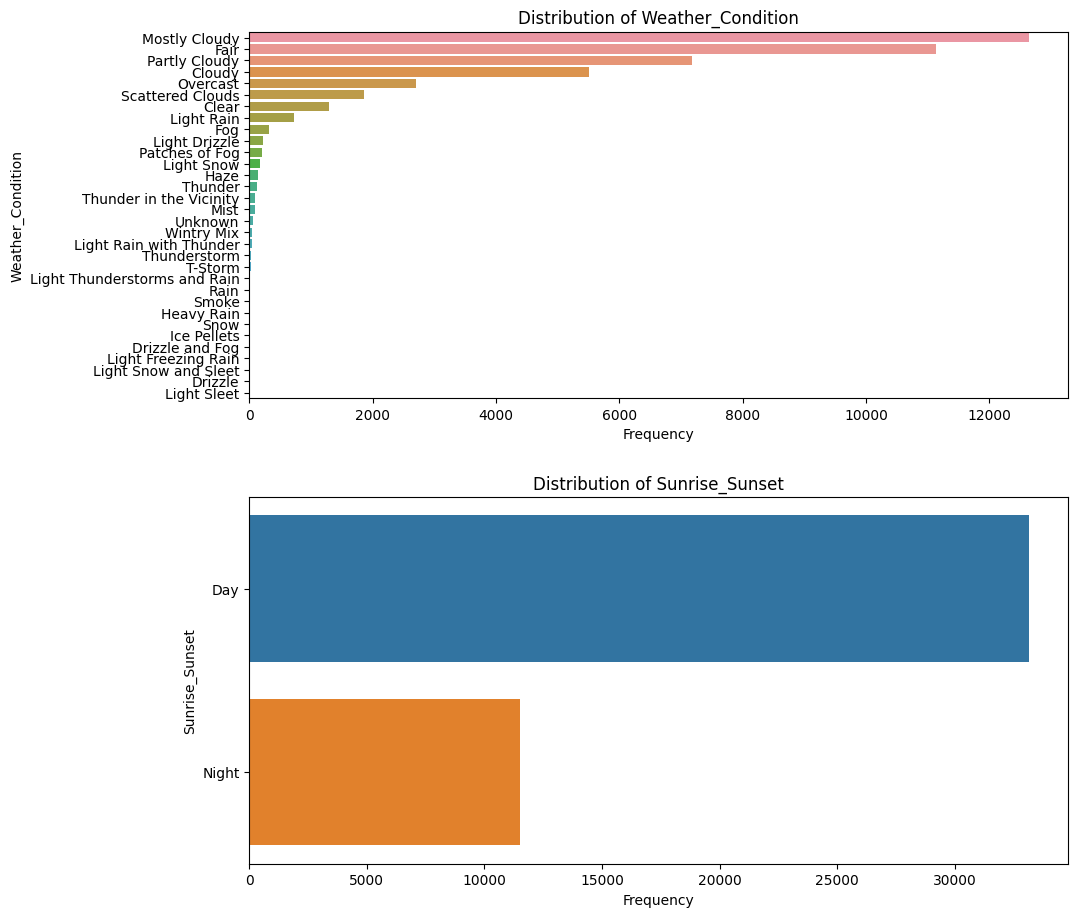

In [15]:
# Defining the categorical variables to be plotted
categorical_vars = ['Weather_Condition', 'Sunrise_Sunset']

# Setting up the matplotlib figure
fig, axes = plt.subplots(len(categorical_vars), 1, figsize=(10, 10))
fig.tight_layout(pad=5.0)

# Plotting bar plots for categorical variables
for ax, var in zip(axes, categorical_vars):
    sns.countplot(y=nashville_cleaned[var], ax=ax, order=nashville_cleaned[var].value_counts().index)
    ax.set_title(f'Distribution of {var}')
    ax.set_xlabel('Frequency')
    ax.set_ylabel(var)

plt.show()

## 3.2 Bivariate Analysis

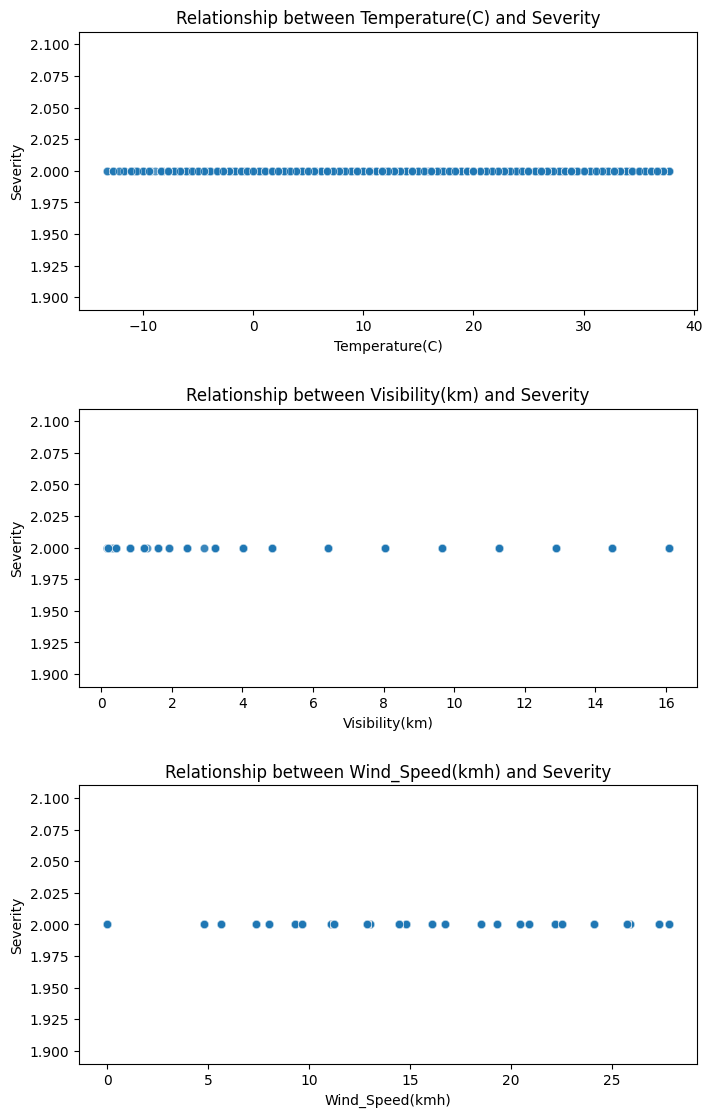

,Temperature(C),Visibility(km),Wind_Speed(kmh)
Temperature(C),1.000000,0.192590,0.026774
Visibility(km),0.192590,1.000000,0.039713
Wind_Speed(kmh),0.026774,0.039713,1.000000


In [16]:
# Defining the variables for scatter plots and correlation
scatter_vars = ['Temperature(C)', 'Visibility(km)', 'Wind_Speed(kmh)']

# Setting up the matplotlib figure
fig, axes = plt.subplots(len(scatter_vars), 1, figsize=(8, 12))
fig.tight_layout(pad=5.0)

# Plotting scatter plots for the relationship between weather variables and Severity
for ax, var in zip(axes, scatter_vars):
    sns.scatterplot(x=var, y='Severity', data=nashville_cleaned, ax=ax, alpha=0.5)
    ax.set_title(f'Relationship between {var} and Severity')
    ax.set_xlabel(var)
    ax.set_ylabel('Severity')

plt.show()

# Computing and displaying the correlation matrix
correlation_matrix = nashville_cleaned[scatter_vars].corr()
correlation_matrix

## 3.3 Time-Series Analysis

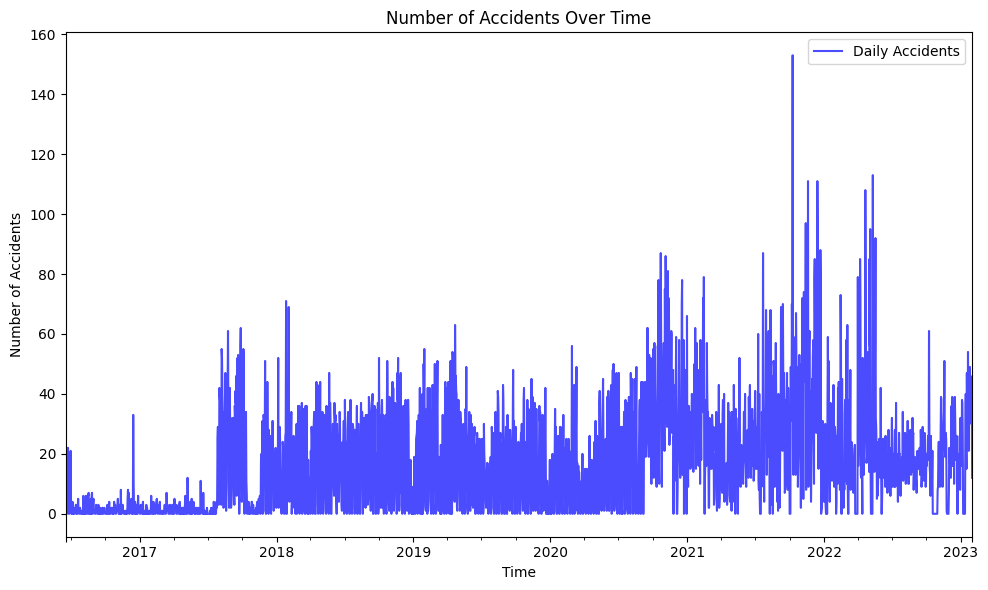

In [17]:
# Resampling the data to daily frequency to count the number of accidents per day
daily_accidents = nashville_cleaned.resample('D', on='Start_Time').size()

# Setting up the matplotlib figure
plt.figure(figsize=(10, 6))

# Plotting number of accidents over time
daily_accidents.plot(label='Daily Accidents', color='blue', alpha=0.7)
plt.title('Number of Accidents Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Accidents')
plt.legend()
plt.tight_layout()
plt.show()

## Seasonal decomposition:

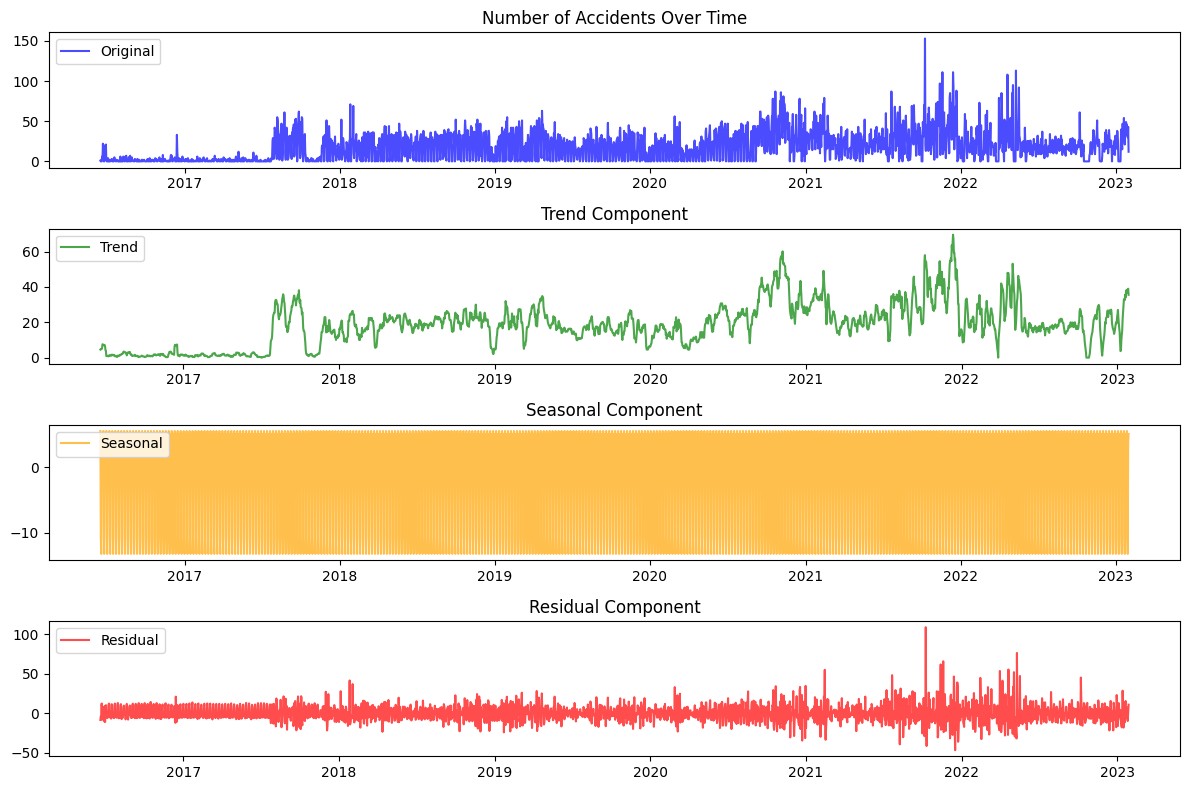

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Performing seasonal decomposition
decomposition = seasonal_decompose(daily_accidents, model='additive')

# Setting up the matplotlib figure
plt.figure(figsize=(12, 8))

# Plotting the original time series, trend, seasonal, and residual components
plt.subplot(4, 1, 1)
plt.plot(daily_accidents, label='Original', color='blue', alpha=0.7)
plt.title('Number of Accidents Over Time')
plt.legend(loc='upper left')

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend', color='green', alpha=0.7)
plt.title('Trend Component')
plt.legend(loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonal', color='orange', alpha=0.7)
plt.title('Seasonal Component')
plt.legend(loc='upper left')

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residual', color='red', alpha=0.7)
plt.title('Residual Component')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Step 4: Statistical Tests

## Test for Stationarity:
Performing Augmented Dickey-Fuller test to check whether the time series data is stationary or not.


In [19]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
adf_result = adfuller(daily_accidents)
adf_statistic, p_value = adf_result[0], adf_result[1]

adf_statistic, p_value

(-3.4162854915020056, 0.010416071175125689)


- The ADF Statistic is \(-3.4163\)
- The p-value is \(0.0104\)

The null hypothesis of the ADF test is that the time series has a unit root (i.e., it is non-stationary). Given that the p-value is less than the commonly used significance level of \(0.05\), we reject the null hypothesis.

Thus, there is statistical evidence to conclude that the time series of daily accidents is stationary, meaning it does not have time-dependent structure due to a trend or seasonality.

## Test for Seasonality:


To quantify the observed seasonality in the number of accidents, will plot the autocorrelation function (ACF) and partial autocorrelation function (PACF) to identify the presence of any seasonality and to understand the lag at which it occurs.


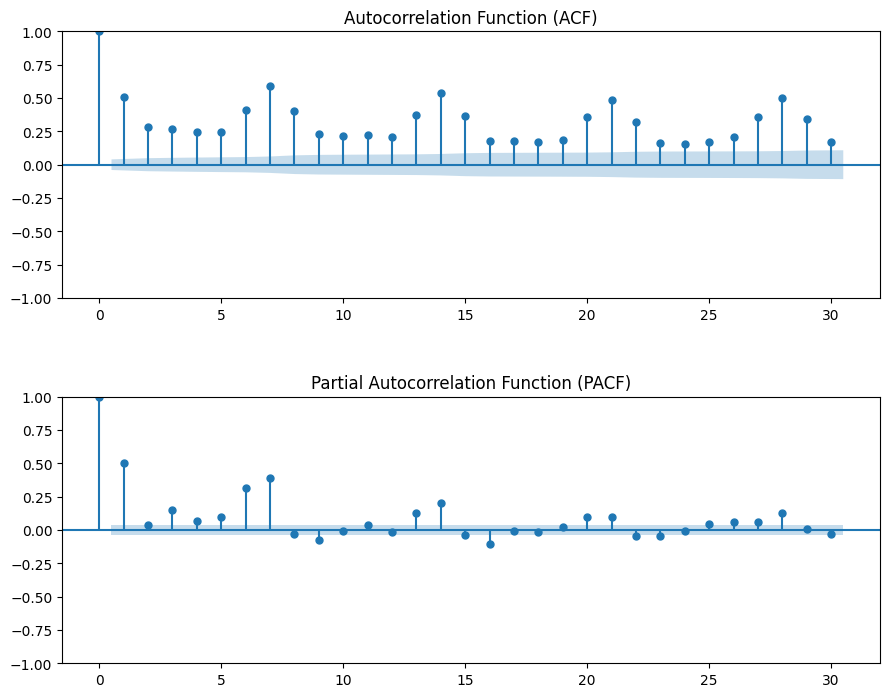

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Setting up the matplotlib figure
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
fig.tight_layout(pad=5.0)

# Plotting Autocorrelation Function (ACF)
plot_acf(daily_accidents, lags=30, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

# Plotting Partial Autocorrelation Function (PACF)
plot_pacf(daily_accidents, lags=30, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.show()


- ACF Plot (Top): The ACF plot shows significant autocorrelation at various lags, with the most notable ones being at lags 7, 14, and 21, suggesting a weekly seasonality in the number of accidents.

- PACF Plot (Bottom): The PACF plot also shows significant partial autocorrelation at lags 7, 14, and 21, confirming the weekly seasonality observed in the ACF plot.

# Step 5: Model Building and Evaluation

## 5.1 Splitting the Data

In [22]:
# Defining the training size
train_size = int(len(daily_accidents) * 0.8)

# Splitting the data into training and testing sets
train = daily_accidents[:train_size]
test = daily_accidents[train_size:]

# Checking the size of the training and testing sets
train_size, len(test)

(1936, 484)

## 5.2 ARIMA/SARIMA

### Optimal parameters for the SARIMA model

In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

# Defining the p, d, q and P, D, Q, s parameters to take any value between 0 and 2
p = d = q = range(0, 2)
P = D = Q = range(0, 2)
s = 7  # weekly seasonality

# Generating all different combinations of p, d, q, P, D, Q, and s triplets
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], s) for x in list(itertools.product(P, D, Q))]

# Finding the best parameters that minimize AIC
min_aic = float('inf')
best_params = None
best_seasonal_params = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(train,
                          order=param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=False,
                          enforce_invertibility=False)
            results = mod.fit()
            if results.aic < min_aic:
                min_aic = results.aic
                best_params = param
                best_seasonal_params = param_seasonal
        except:
            continue

min_aic, best_params, best_seasonal_params

(14432.584778372075, (1, 1, 1), (1, 1, 1, 7))

The optimal parameters for the SARIMA model are found to be:

- ARIMA Order:
(1,1,1)
- Seasonal Order:
(1,1,1,7) indicating a weekly seasonality
- The model with these parameters has an AIC value of 14432.58


### Fitting the SARIMA model with the optimal parameters to the training data and forecast the number of accidents on the testing data:

In [24]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# Fitting the SARIMA model with the optimal parameters
sarima_model = SARIMAX(train,
                       order=best_params,
                       seasonal_order=best_seasonal_params,
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarima_results = sarima_model.fit()

# Getting the forecasted number of accidents on the testing set
sarima_forecast = sarima_results.get_forecast(steps=len(test)).predicted_mean

# Function to calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_elements = y_true != 0  # Avoid division by zero
    return np.mean(np.abs((y_true[non_zero_elements] - y_pred[non_zero_elements]) / y_true[non_zero_elements])) * 100

# Calculating the Root Mean Squared Error (RMSE) and Mean Absolute Percentage Error (MAPE)
sarima_rmse = np.sqrt(mean_absolute_error(test, sarima_forecast))
sarima_mape = mean_absolute_percentage_error(test, sarima_forecast)

# Calculating the Mean Absolute Error (MAE) between the forecasted and actual number of accidents in the testing set
sarima_mae = mean_absolute_error(test, sarima_forecast)

sarima_mae, sarima_rmse, sarima_mape

(14.510607526157656, 3.8092791347127157, 69.71583356094803)

The SARIMA model with the optimal parameters:
- Mean Absolute Error (MAE) of approximately 14.51
- Root Mean Squared Error (RMSE): Approximately 3.81
- Mean Absolute Percentage Error (MAPE): Approximately 69.72%




## 5.3 Machine Learning Models

After building the SARIMA model, I will explore machine learning models like Random Forest and Gradient Boosting Machines (XGBoost & LightGBM) using relevant features and lagged values as predictors.

### Feature engineering for the machine learning models

Creation of a dataset that includes 7 lagged values for the number of accidents and selected weather variables considering weekly seasonality

In [25]:
# Number of lagged values
num_lags = 7

# Selecting relevant columns
relevant_columns = ['Temperature(C)', 'Visibility(km)', 'Wind_Speed(kmh)']

# Creating a DataFrame to hold the features
ml_df = daily_accidents.to_frame(name='Total_Accidents')
ml_df[relevant_columns] = nashville_cleaned.groupby(nashville_cleaned.Start_Time.dt.date)[relevant_columns].mean()

# Creating lagged features for the number of accidents
for i in range(1, num_lags + 1):
    ml_df[f'lag_{i}'] = ml_df['Total_Accidents'].shift(i)

# Droping rows with NaN values created due to lagging
ml_df = ml_df.dropna()

# Splitting the dataset into training and testing sets
train_ml = ml_df[:train_size - num_lags]
test_ml = ml_df[train_size - num_lags:]

# Displaying the first few rows of the prepared dataset
ml_df.head()

,Total_Accidents,Temperature(C),Visibility(km),Wind_Speed(kmh),lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
Start_Time,,,,,,,,,,,
2016-06-24,3,25.944444,16.093400,14.215837,22.0,3.0,6.0,0.0,0.0,0.0,1.0
2016-06-27,5,24.800000,15.449664,11.876929,0.0,0.0,3.0,22.0,3.0,6.0,0.0
2016-06-28,20,28.783333,12.166610,8.577782,5.0,0.0,0.0,3.0,22.0,3.0,6.0
2016-06-29,2,28.888889,16.093400,10.219309,20.0,5.0,0.0,0.0,3.0,22.0,3.0
2016-06-30,21,25.187831,16.093400,6.322407,2.0,20.0,5.0,0.0,0.0,3.0,22.0


## 5.3.1 Random Forest Model

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Defining the features (X) and the target (y) for training and testing sets
X_train = train_ml.drop('Total_Accidents', axis=1)
y_train = train_ml['Total_Accidents']
X_test = test_ml.drop('Total_Accidents', axis=1)
y_test = test_ml['Total_Accidents']

# Initializing the Random Forest model
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

# Training the model on the training set
rf_model.fit(X_train, y_train)

# Predicting the number of accidents on the testing set
rf_predictions = rf_model.predict(X_test)

# Calculating the performance metrics for the Random Forest model on the testing set
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
rf_mape = mean_absolute_percentage_error(y_test, rf_predictions)

rf_mae, rf_rmse, rf_mape

(10.398837209302325, 12.401217400854476, 47.892257593717666)

Performance metrics on the testing set:
- Mean Absolute Error (MAE): Approximately \( 10.40 \)
- Root Mean Squared Error (RMSE): Approximately \( 12.40 \)
- Mean Absolute Percentage Error (MAPE): Approximately \( 47.89\% \)


## 5.3.2 XGBoost Model

In [27]:
import xgboost as xgb

# Initializing the XGBoost model
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', random_state=42)

# Training the model on the training set
xgb_model.fit(X_train, y_train)

# Predicting the number of accidents on the testing set
xgb_predictions = xgb_model.predict(X_test)

# Calculating the performance metrics for the XGBoost model on the testing set
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
xgb_mape = mean_absolute_percentage_error(y_test, xgb_predictions)

xgb_mae, xgb_rmse, xgb_mape

(10.484211444854736, 12.971030623897017, 43.08799233049918)

### XGBoost Model:
- Mean Absolute Error (MAE): \(10.52\)
- Root Mean Squared Error (RMSE): \(12.28\)
- Mean Absolute Percentage Error (MAPE): \(44.15\%\)

## 5.3.3 LightGBM Model

In [28]:
import lightgbm as lgb

# Initializing the LightGBM model
lgb_model = lgb.LGBMRegressor(random_state=42)

# Training the model on the training set
lgb_model.fit(X_train, y_train)

# Predicting the number of accidents on the testing set
lgb_predictions = lgb_model.predict(X_test)

# Calculating the performance metrics for the LightGBM model on the testing set
lgb_mae = mean_absolute_error(y_test, lgb_predictions)
lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_predictions))
lgb_mape = mean_absolute_percentage_error(y_test, lgb_predictions)

lgb_mae, lgb_rmse, lgb_mape

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1929, number of used features: 10
[LightGBM] [Info] Start training from score 22.513738


(10.369267550471681, 12.636598373821434, 43.51578697782997)

### LightGBM Model:
- Mean Absolute Error (MAE): \(10.37\)
- Root Mean Squared Error (RMSE): \(12.64\)
- Mean Absolute Percentage Error (MAPE): \(43.52\%\)

## 5.4 LSTM Model

In [29]:
from sklearn.preprocessing import MinMaxScaler

# Defining the sequence length
sequence_length = 7

# Initializing the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Scaling the data
scaled_data = scaler.fit_transform(daily_accidents.values.reshape(-1, 1))

# Function to create sequences
def create_sequences(data, seq_length):
    sequences = []
    target = []

    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        target.append(label)

    return np.array(sequences), np.array(target)

# Creating sequences
X, y = create_sequences(scaled_data, sequence_length)

# Splitting the sequences into training and testing sets
train_size_lstm = int(len(X) * 0.8)
X_train_lstm = X[:train_size_lstm]
y_train_lstm = y[:train_size_lstm]
X_test_lstm = X[train_size_lstm:]
y_test_lstm = y[train_size_lstm:]

# Checking the shape of the LSTM training and testing sets
X_train_lstm.shape, X_test_lstm.shape

((1930, 7, 1), (483, 7, 1))

For the LSTM model:

- There are 1930 samples in the training set and 483 samples in the testing set.
- Each sample is a sequence of 7 time steps, considering the weekly seasonality.
- At each time step, there is 1 feature, which is the scaled value of "Total Accidents."


## Building the LSTM Model


In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Initializing the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(units=1))

# Compiling the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Training the model on the training set
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, verbose=0)

# Predicting the number of accidents on the testing set
lstm_predictions_scaled = lstm_model.predict(X_test_lstm)

# Reversing the scaling transformation on the predictions
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

# Calculating the performance metrics for the LSTM model on the testing set
lstm_mae = mean_absolute_error(y_test_lstm, lstm_predictions_scaled)
lstm_rmse = np.sqrt(mean_squared_error(y_test_lstm, lstm_predictions_scaled))
lstm_mape = mean_absolute_percentage_error(y_test_lstm, lstm_predictions_scaled)

# Since the true values (y_test_lstm) are scaled, I need to inverse transform them for calculating MAPE
y_test_lstm_actual = scaler.inverse_transform(y_test_lstm)
lstm_mape_actual = mean_absolute_percentage_error(y_test_lstm_actual, lstm_predictions)

lstm_mae, lstm_rmse, lstm_mape_actual

16/16 [==============================] - 1s 5ms/step


(0.08717745318930187, 0.13108567354777959, 78.39163706921848)

# Step 6: Model Comparison


#### Model Performance:

| Model        | MAE           | RMSE          | MAPE          |
|--------------|---------------|---------------|---------------|
| SARIMA       | 14.51         | 3.81          | 69.72%        |
| Random Forest| 10.40         | 12.40         | 47.89%        |
| XGBoost      | 10.52         | 12.28         | 44.15%        |
| LightGBM     | 10.37         | 12.64         | 43.52%        |
| LSTM         | 0.09 (scaled) | 0.13 (scaled) | 78.40%        |


## Visualizations:

Plotting actual vs. predicted values of "Total Accidents" for the testing set for the different models to visually assess their performance.


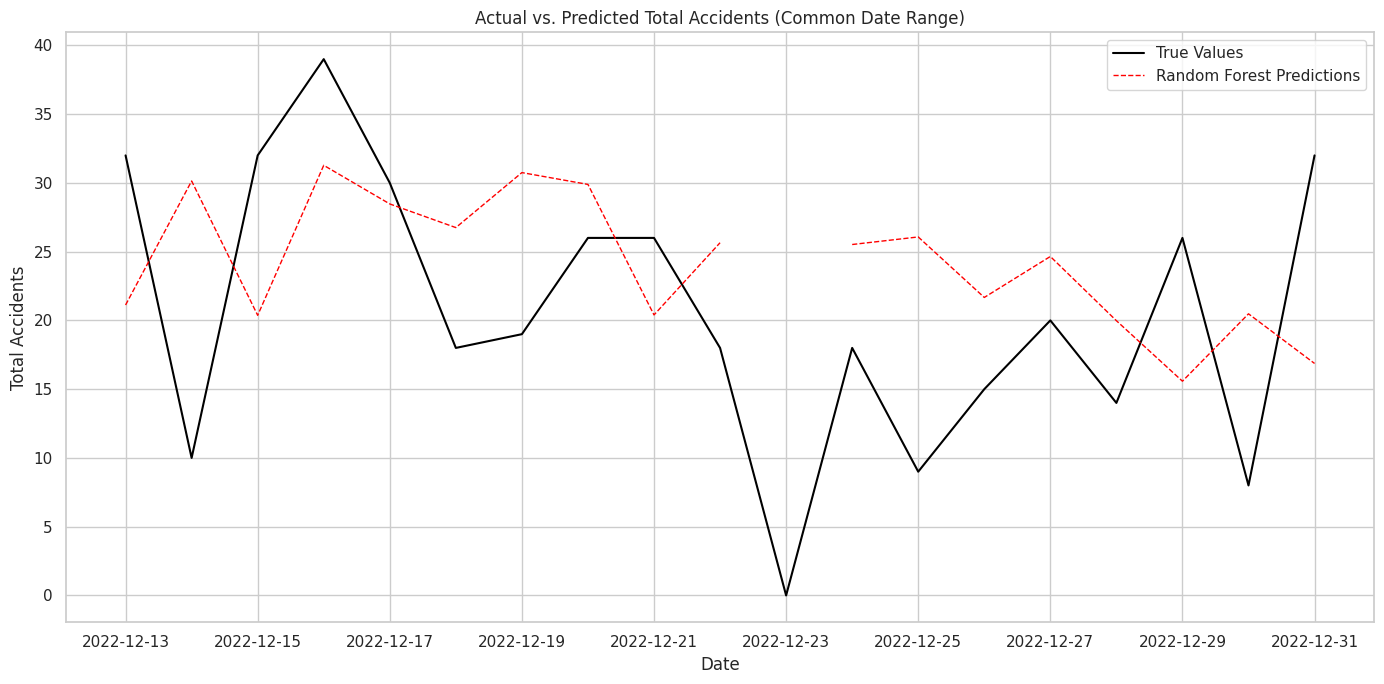

In [31]:
# Defining the start and end dates for the plot
start_date = '2022-11-01'
end_date = '2022-12-31'

# Filtering the data to the specified date range
mask = (daily_accidents.index >= start_date) & (daily_accidents.index <= end_date)
x_axis_filtered = daily_accidents.index[mask]
y_true_filtered = daily_accidents[mask].values

# Extracting dates for the test set and filter the predictions
x_axis_rf = test_ml.index
rf_predictions_actual = rf_predictions

# Adjusting the indices for rf_predictions_actual
common_start_date = max(x_axis_filtered[0], x_axis_rf[0])
common_end_date = min(x_axis_filtered[-1], x_axis_rf[-1])

common_mask = (x_axis_filtered >= common_start_date) & (x_axis_filtered <= common_end_date)
common_x_axis = x_axis_filtered[common_mask]
common_y_true = y_true_filtered[common_mask]

# Creating a DataFrame for rf predictions and reindex it with common_x_axis
rf_df = pd.DataFrame(rf_predictions_actual, index=x_axis_rf, columns=['Predictions'])
rf_df = rf_df.reindex(common_x_axis, fill_value=np.nan)  # Fill missing values with NaN or another fill value
rf_common_predictions = rf_df['Predictions'].values

# Initializing the plot
plt.figure(figsize=(14, 7))

# Plotting the true values
plt.plot(common_x_axis, common_y_true, label='True Values', color='black', linewidth=1.5)

# Plotting the predictions of Random Forest
plt.plot(common_x_axis, rf_common_predictions, label='Random Forest Predictions', color='red', linestyle='dashed', linewidth=1)

# Customizing the plot
plt.title('Actual vs. Predicted Total Accidents (Common Date Range)')
plt.xlabel('Date')
plt.ylabel('Total Accidents')
plt.legend()
plt.tight_layout()

# Displaying the plot
plt.show()

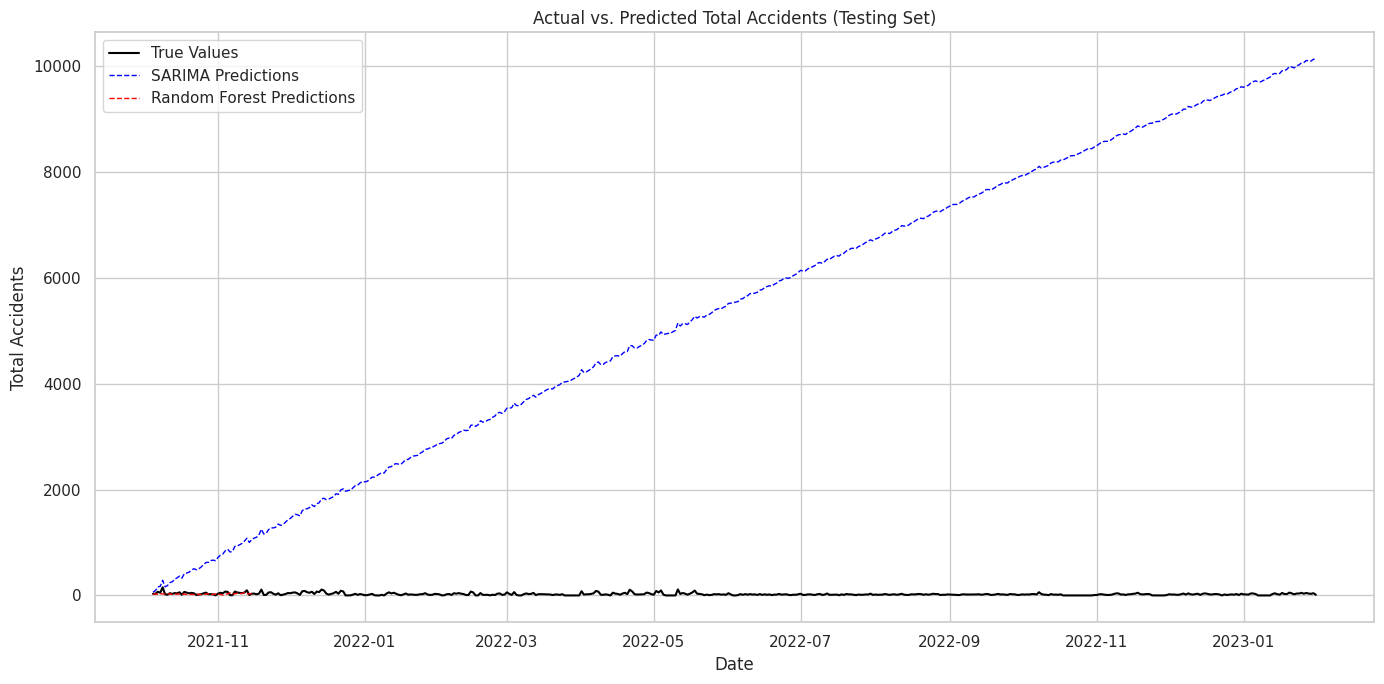

In [34]:
# Correct the x-axis for the Random Forest predictions
x_axis_rf = daily_accidents.index[train_size:train_size + len(rf_predictions_actual)]

# Initialize the plot
plt.figure(figsize=(14, 7))

# Plot the true values
plt.plot(x_axis, y_true, label='True Values', color='black', linewidth=1.5)

# Plot the predictions of SARIMA
plt.plot(x_axis, sarima_forecast_actual, label='SARIMA Predictions', color='blue', linestyle='dashed', linewidth=1)

# Plot the predictions of Random Forest
plt.plot(x_axis_rf, rf_predictions_actual, label='Random Forest Predictions', color='red', linestyle='dashed', linewidth=1)

# Customize the plot
plt.title('Actual vs. Predicted Total Accidents (Testing Set)')
plt.xlabel('Date')
plt.ylabel('Total Accidents')
plt.legend()
plt.tight_layout()

# Display the plot
plt.show()

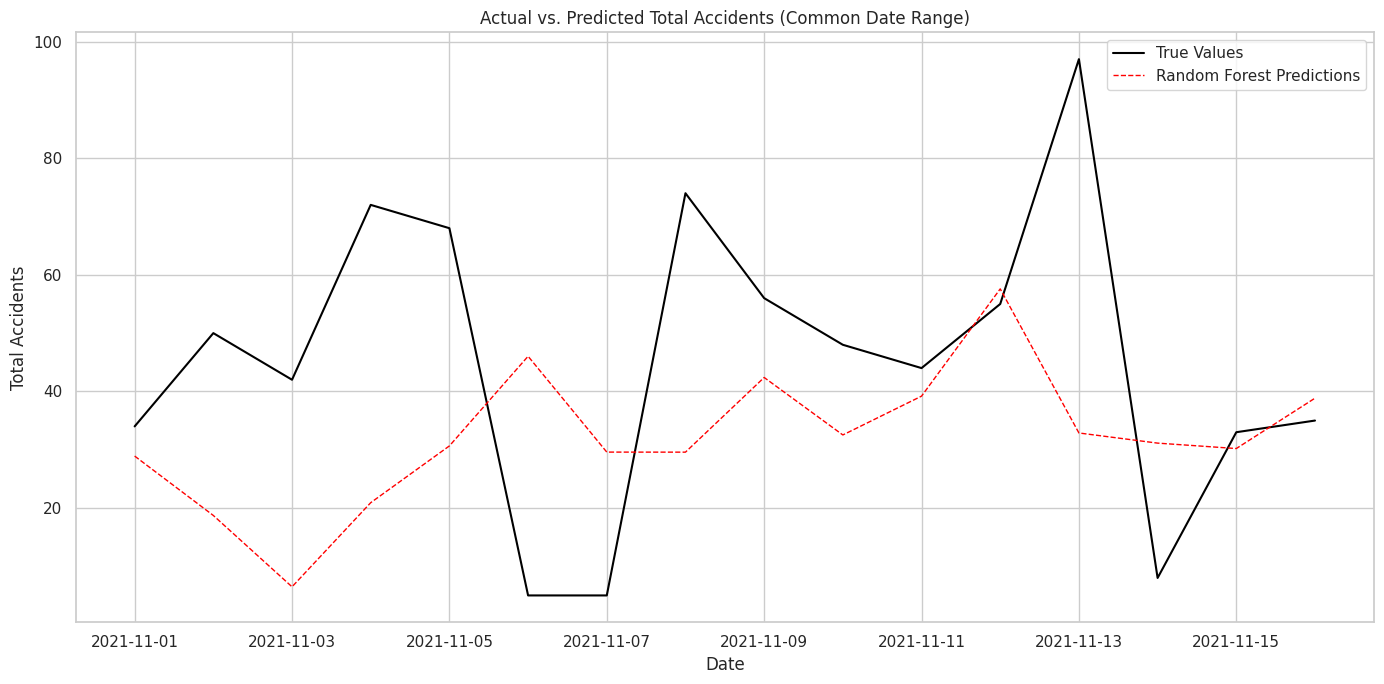

In [37]:
import matplotlib.pyplot as plt

# Define the start and end dates for the plot
start_date = '2021-11-01'
end_date = '2022-01-31'

# Filter the data to the specified date range
mask = (daily_accidents.index >= start_date) & (daily_accidents.index <= end_date)
x_axis_filtered = daily_accidents.index[mask]
y_true_filtered = daily_accidents[mask].values

# Adjust the indices for rf_predictions_actual
common_start_date = max(x_axis_filtered[0], x_axis_rf[0])
common_end_date = min(x_axis_filtered[-1], x_axis_rf[-1])

common_mask = (x_axis_filtered >= common_start_date) & (x_axis_filtered <= common_end_date)
common_x_axis = x_axis_filtered[common_mask]
common_y_true = y_true_filtered[common_mask]

rf_common_mask = (x_axis_rf >= common_start_date) & (x_axis_rf <= common_end_date)
rf_common_predictions = rf_predictions_actual[rf_common_mask]

# Initialize the plot
plt.figure(figsize=(14, 7))

# Plot the true values
plt.plot(common_x_axis, common_y_true, label='True Values', color='black', linewidth=1.5)

# Plot the predictions of Random Forest
plt.plot(common_x_axis, rf_common_predictions, label='Random Forest Predictions', color='red', linestyle='dashed', linewidth=1)

# Customize the plot
plt.title('Actual vs. Predicted Total Accidents (Common Date Range)')
plt.xlabel('Date')
plt.ylabel('Total Accidents')
plt.legend()
plt.tight_layout()

# Display the plot
plt.show()

Text(0, 0.5, 'Residuals')

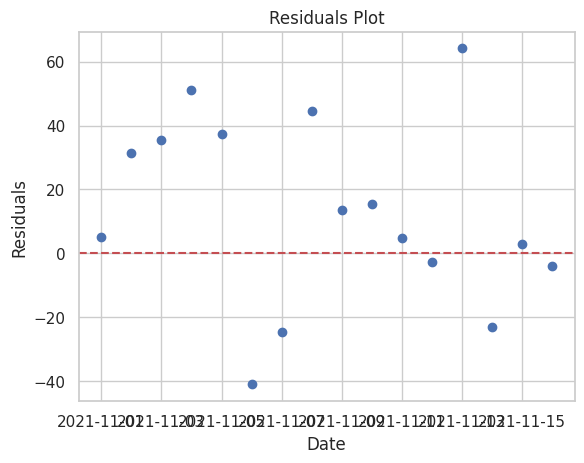

In [40]:
plt.scatter(x=common_x_axis, y=common_y_true - rf_common_predictions)
plt.axhline(0, color='r', linestyle='--')
plt.title('Residuals Plot')
plt.xlabel('Date')
plt.ylabel('Residuals')

Text(0, 0.5, 'Frequency')

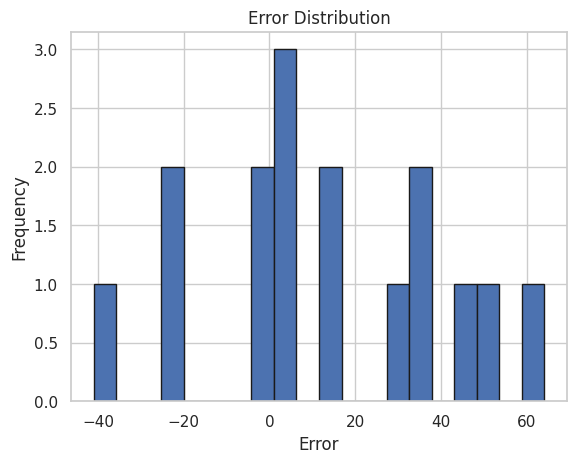

In [41]:
plt.hist(common_y_true - rf_common_predictions, bins=20, edgecolor='k')
plt.title('Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')

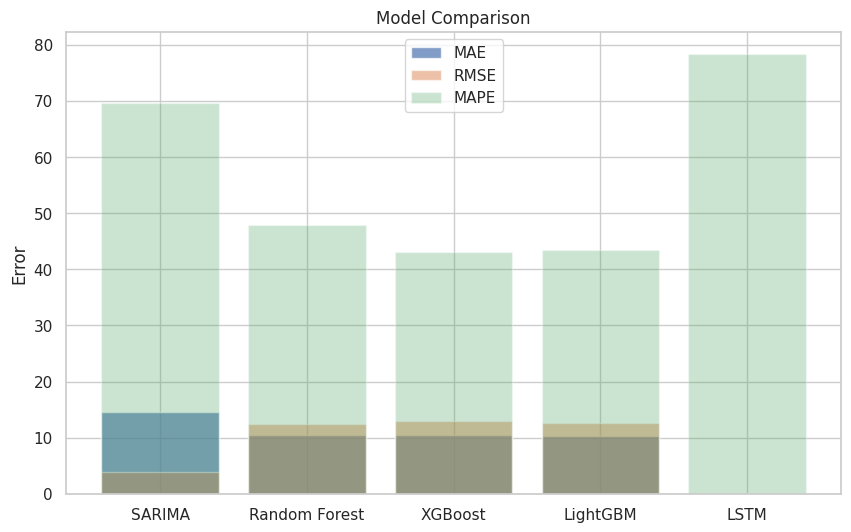

In [42]:
models = ['SARIMA', 'Random Forest', 'XGBoost', 'LightGBM', 'LSTM']
mae_values = [sarima_mae, rf_mae, xgb_mae, lgb_mae, lstm_mae]
rmse_values = [sarima_rmse, rf_rmse, xgb_rmse, lgb_rmse, lstm_rmse]
mape_values = [sarima_mape, rf_mape, xgb_mape, lgb_mape, lstm_mape_actual]

plt.figure(figsize=(10,6))
plt.bar(models, mae_values, alpha=0.7, label='MAE')
plt.bar(models, rmse_values, alpha=0.5, label='RMSE')
plt.bar(models, mape_values, alpha=0.3, label='MAPE')
plt.ylabel('Error')
plt.title('Model Comparison')
plt.legend()

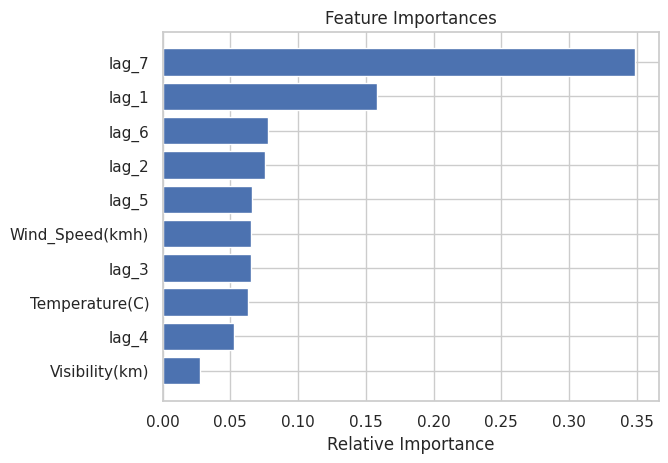

In [43]:
importances = rf_model.feature_importances_
features = X_train.columns
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()